In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
# Data Preprocessing
# Download the CIFAR-10 dataset
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!mkdir cifar-10
!tar -xzvf cifar-10-python.tar.gz -C cifar-10/

--2024-01-10 13:37:59--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

mkdir: cannot create directory ‘cifar-10’: File exists
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
# Importing the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Transformation
transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5



In [ ]:
# Loading the data

batch_size = 4
num_workers = 0
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

# load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

# put 10 classes into a set
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


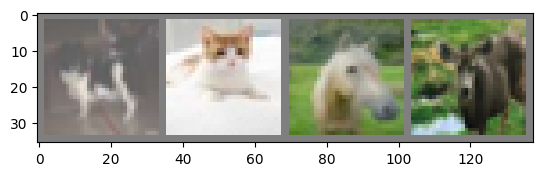

dog cat horse deer


In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))


In [ ]:
# Defining the CNN
class Net(nn.Module):

    def __init__(self):

        super(Net, self).__init__()
	# 3 input image channel, 6 output channels,
	# 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
	# Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)# 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
print(Net)


<class '__main__.Net'>


In [ ]:
# Optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss is used as it combines LogSoftmax and NLLLoss
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Training the model
num_epochs = 5 # Adjust as needed

model.train()

for epoch in range(num_epochs):
    for inputs, targets in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

In [ ]:
print("Finished Training")

Finished Training


**TO IMPLEMENT UNCERTAINITY MEASURE**

**TO IMPLEMENT USING LEAST CONFIDENCE METHOD**

Sample 0: Least Confidence = 0.0009


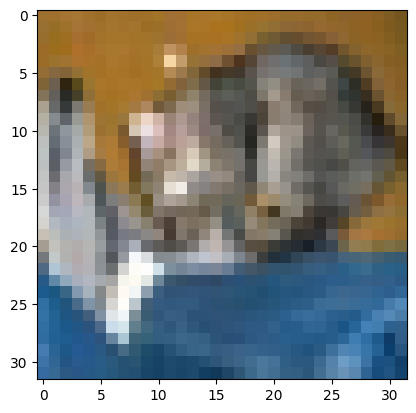

True Label: cat, Predicted: dog

Sample 1: Least Confidence = 0.0000


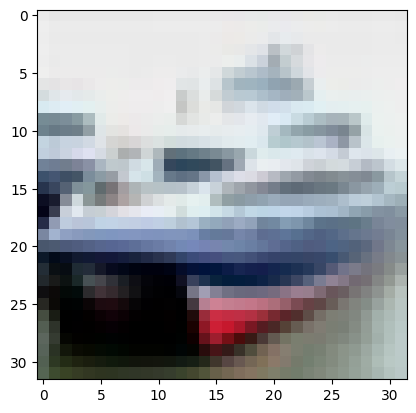

True Label: ship, Predicted: ship

Sample 2: Least Confidence = 0.0029


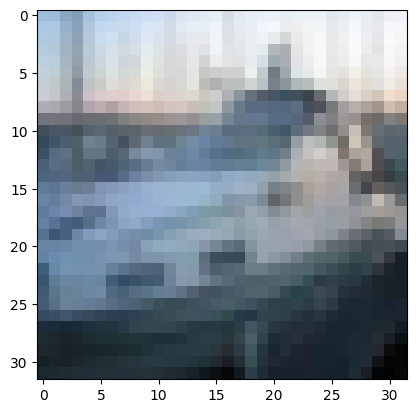

True Label: ship, Predicted: plane

Sample 3: Least Confidence = 0.0001


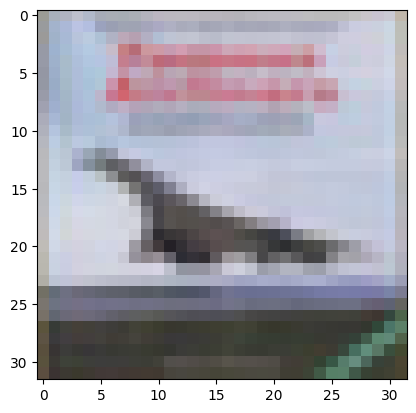

True Label: plane, Predicted: plane

Sample 4: Least Confidence = 0.0011


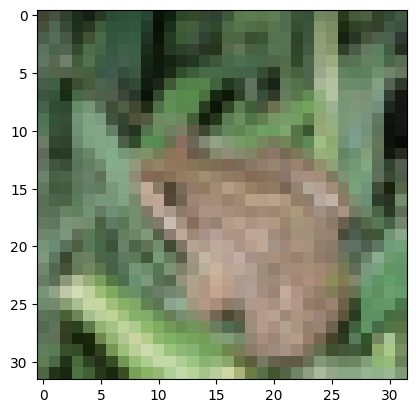

True Label: frog, Predicted: deer

Accuracy of the model on the test data: 50.00%


In [23]:
# Switch model to evaluation mode
model.eval()

least_confidence_threshold=0.5

# Set the maximum number of samples to display
max_display_samples = 5

# Counter for displayed samples
displayed_samples = 0

# Initialize variables to track performance
total_samples = 0
correct_predictions = 0

# Disable gradient computations
with torch.no_grad():
    for inputs, targets in testloader:
        outputs = model(inputs)

        # Get the predicted class (the one with the highest probability)
        _, predicted = torch.max(outputs.data, 1)



        # Calculate confidence scores using softmax
        softmax_probs = F.softmax(outputs, dim=1)
        # Get the least confidence score for each sample
        least_confidence_scores, _ = torch.min(softmax_probs, dim=1)
        # Identify and print samples with the lowest confidence
        for i in range(len(targets)):
            if least_confidence_scores[i] < least_confidence_threshold:
                print(f"Sample {total_samples + i}: Least Confidence = {least_confidence_scores[i]:.4f}")
                imshow(torchvision.utils.make_grid(inputs[i]))
                print(f"True Label: {classes[targets[i]]}, Predicted: {classes[predicted[i]]}\n")

                # Increment the counter for displayed samples
                displayed_samples += 1

                # Check if the maximum number of samples to display is reached
                if displayed_samples >= max_display_samples:
                    break

        # Update total and correct counts
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

        # Check if the maximum number of samples to display is reached
        if displayed_samples >= max_display_samples:
            break

# Calculate accuracy
accuracy = 100 * correct_predictions / total_samples
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')

**TO IMPLEMENT USING PREDICTION ENTROPY METHOD**

In [ ]:
# Set a threshold for prediction entropy
high_entropy_threshold = 2.0  # Adjust as needed

# Set the maximum number of samples to display
max_display_samples = 5  # Adjust as needed

# Counter for displayed samples
displayed_samples = 0

# Disable gradient computations
with torch.no_grad():
    for inputs, targets in testloader:
        outputs = model(inputs)

        # Get the predicted class (the one with the highest probability)
        _, predicted = torch.max(outputs.data, 1)

        # Calculate entropy of the predicted probability distribution
        entropy = -torch.sum(F.softmax(outputs, dim=1) * F.log_softmax(outputs, dim=1), dim=1)

        # Identify and print samples with high entropy
        for i in range(len(targets)):
            if entropy[i] > high_entropy_threshold:
                print(f"Sample {total_samples + i}: Prediction Entropy = {entropy[i]:.4f}")
                imshow(torchvision.utils.make_grid(inputs[i]))
                print(f"True Label: {classes[targets[i]]}, Predicted: {classes[predicted[i]]}\n")

                # Increment the counter for displayed samples
                displayed_samples += 1

                # Check if the maximum number of samples to display is reached
                if displayed_samples >= max_display_samples:
                    break
        # Update total and correct counts
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

        # Check if the maximum number of samples to display is reached
        if displayed_samples >= max_display_samples:
            break


**Margin Sampling**

In [38]:

# Set the maximum number of samples to display
max_display_samples = 5  # Adjust as needed

# Counter for displayed samples
displayed_samples = 0

# Initialize variables to track performance
total_samples = 0

# Set a threshold for margin sampling
margin_threshold = 0.2  # Adjust as needed

# Disable gradient computations
with torch.no_grad():
    for inputs, targets in testloader:
        outputs = model(inputs)

        # Get the predicted class (the one with the highest probability)
        _, predicted = torch.max(outputs.data, 1)

        # Calculate confidence scores using softmax
        softmax_probs = F.softmax(outputs, dim=1)

        # Sort the confidence scores and get the top two values and classes
        top2_probs, top2_classes = torch.topk(softmax_probs, 2, dim=1)

        # Calculate the margin (difference between top two confidence scores)
        margin = top2_probs[:, 0] - top2_probs[:, 1]

        # Identify and print samples with margin below the threshold
        for i in range(len(targets)):
            if margin[i] < margin_threshold:
                print(f"Sample {total_samples + i}: Margin = {margin[i]:.4f}")

                print(f"True Label: {classes[targets[i]]}, Predicted: {classes[predicted[i]]}\n")

        # Increment the counter for displayed samples
                displayed_samples += 1

                # Check if the maximum number of samples to display is reached
                if displayed_samples >= max_display_samples:
                    break
        # Update total count
        total_samples += len(targets)
        # Check if the maximum number of samples to display is reached
        if displayed_samples >= max_display_samples:
            break




Sample 0: Margin = 0.0074
True Label: cat, Predicted: dog

Sample 2: Margin = 0.0664
True Label: ship, Predicted: plane

Sample 6: Margin = 0.1951
True Label: car, Predicted: truck

Sample 10: Margin = 0.0443
True Label: plane, Predicted: deer

Sample 12: Margin = 0.0465
True Label: dog, Predicted: bird



**Contrastive Active Learning using KL divergence between the current sample and its m nearest neighbours**

In [40]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy
from keras.datasets import cifar10  # Assuming you have Keras installed

# Load CIFAR-10 dataset
(x_train, y_train), (_, _) = cifar10.load_data()

# Flatten the images
x_train = x_train.reshape(x_train.shape[0], -1)

# Normalize the data to [0, 1]
x_train = x_train.astype('float32') / 255

# Set the number of neighbors (m)
m = 5

# Function to calculate KL divergence between two probability distributions
def kl_divergence(p, q):
    return entropy(p, q)

# Function to calculate KL divergence between a sample and its m nearest neighbors
def calculate_kl_divergence(sample, neighbors):
    kl_divergences = [kl_divergence(sample, neighbor) for neighbor in neighbors]
    return np.mean(kl_divergences)

# Function to perform Contrastive Active Learning on CIFAR-10
def contrastive_active_learning(x, m):
    # Fit a nearest neighbors model
    nn_model = NearestNeighbors(n_neighbors=m)
    nn_model.fit(x)

    # Get indices of neighbors for each sample
    neighbor_indices = nn_model.kneighbors(x, return_distance=False)

    # Initialize an array to store KL divergences
    kl_divergences = np.zeros(x.shape[0])

    # Calculate KL divergences for each sample
    for i in range(x.shape[0]):
        sample = x[i]
        neighbors = x[neighbor_indices[i]]
        kl_divergences[i] = calculate_kl_divergence(sample, neighbors)

    # Sort indices based on KL divergences
    selected_indices = np.argsort(kl_divergences)

    return selected_indices

# Perform Contrastive Active Learning
selected_indices = contrastive_active_learning(x_train, m)

# Print the selected indices (samples)
print("Selected Indices:", selected_indices)


170498071/170498071 [==============================] - 4s 0us/step
Selected Indices: [ 9985 18617  9881 ... 12329 12350 12092]


**TO IMPLEMENT DIVERISITY USING COSINE SIMILARITY**

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

# Set the number of neighbors (m)
m = 5

# Function to calculate average cosine similarity between a sample and its m nearest neighbors
def calculate_average_cosine_similarity(sample, neighbors):
    cosine_similarities = cosine_similarity([sample], neighbors)[0]
    return np.mean(cosine_similarities)

# Function to perform DIVERSITY on CIFAR-10
def diversity(x, m):
    # Fit a nearest neighbors model
    nn_model = NearestNeighbors(n_neighbors=m)
    nn_model.fit(x)

    # Get indices of neighbors for each sample
    neighbor_indices = nn_model.kneighbors(x, return_distance=False)

    # Initialize an array to store cosine similarities
    cosine_similarities = np.zeros(x.shape[0])

    # Calculate cosine similarities for each sample
    for i in range(x.shape[0]):
        sample = x[i]
        neighbors = x[neighbor_indices[i]]
        cosine_similarities[i] = calculate_average_cosine_similarity(sample, neighbors)

    # Sort indices based on cosine similarities
    selected_indices = np.argsort(cosine_similarities)

    return selected_indices

# Perform DIVERSITY
selected_indices_diversity = diversity(x_train, m)

# Print the selected indices (samples)
print("Selected Indices (DIVERSITY):", selected_indices_diversity)


Selected Indices (DIVERSITY): [44590 24118  9417 ...  9985 40590  9881]


**TO IMPLEMENT DIVERSITY USING L2 NORM BETWEEN A SAMPLE AND ITS NEAREST M NEIGHBORS**

In [45]:
# Set the number of neighbors (m)
m = 5

# Function to calculate average L2 norm between a sample and its m nearest neighbors
def calculate_average_l2_norm(sample, neighbors):
    l2_norms = np.linalg.norm(neighbors - sample, axis=1)
    return np.mean(l2_norms)

# Function to perform DIVERSITY based on L2 norm on CIFAR-10
def diversity_l2_norm(x, m):
    # Fit a nearest neighbors model
    nn_model = NearestNeighbors(n_neighbors=m)
    nn_model.fit(x)

    # Get indices of neighbors for each sample
    neighbor_indices = nn_model.kneighbors(x, return_distance=False)

    # Initialize an array to store L2 norms
    l2_norms = np.zeros(x.shape[0])

    # Calculate L2 norms for each sample
    for i in range(x.shape[0]):
        sample = x[i]
        neighbors = x[neighbor_indices[i]]
        l2_norms[i] = calculate_average_l2_norm(sample, neighbors)

    # Sort indices based on L2 norms
    selected_indices = np.argsort(l2_norms)

    return selected_indices

# Perform DIVERSITY based on L2 norm
selected_indices_diversity_l2_norm = diversity_l2_norm(x_train, m)

# Print the selected indices (samples)
print("Selected Indices (DIVERSITY with L2 norm):", selected_indices_diversity_l2_norm)

Selected Indices (DIVERSITY with L2 norm): [31426 39942  8072 ...  4564  7243 17717]
